In [1]:
from collections import defaultdict
import heapq
import matplotlib
import matplotlib.pyplot as plt
import random
import matplotlib.animation as animation

Definition des variables necessaires

In [2]:
num_rooms_in_trajectory = 4
room_time = 180
transition_time = 30
immersion_groups = []
total_immersion_time = num_rooms_in_trajectory * room_time + (num_rooms_in_trajectory - 1) * transition_time

# Main parameters
room_size = [3, 3]
num_virtual_rooms = room_size[0] * room_size[1]

Definition d'une classe groupe

In [3]:
class Group:
    def __init__(self, group_id, num_people, initial_departure_time, room_time, transition_time, trajectory=[], room_times={}):
        self.group_id = group_id
        self.num_people = num_people
        self.initial_departure_time = initial_departure_time
        self.room_time = room_time
        self.transition_time = transition_time
        self.trajectory = trajectory
        self.room_times = room_times

    def add_room(self, room,):
        self.trajectory.append(room)
        
        # Better to update this directly when adding the room
    def define_room_times(self):
        self.room_times = {room: [] for room in self.trajectory}
        for i in range(len(self.trajectory)):
            self.room_times[self.trajectory[i]].append([self.initial_departure_time + i*(self.room_time + self.transition_time), self.initial_departure_time + (i+1)*(self.room_time) + i*self.transition_time])

    def display_information(self):
        print(f"Group ID: {self.group_id}")
        print(f"Number of people in the group: {self.num_people}")
        print(f"Initial departure time: {self.initial_departure_time}")
        print("Group trajectory:")
        for room in self.trajectory:
            print(f"- {room}")
        for (key, values) in self.room_times.items():
            print((key, values))


Definition des fonctions de populations qui renvoie a un temps t donné, un array qui represente le nombre de personnes presentes dans chacune des 9 salles

In [4]:
def population(t, immersion_groups):
    # It is zero everywhere at the beginning
    room_populations = [0] * num_virtual_rooms

    # Traverse the intervals to find the active groups
    for group in immersion_groups:
        room_times = group.room_times
        for key, values in room_times.items():
            for value in values:
                if value[0] <= t <= value[1]:
                    room_populations[key] += group.num_people
    
    return room_populations

def population_in_point(t, immersion_groups, point):
    # It is zero everywhere at the beginning
    room_population = 0

    # Traverse the intervals to find the active groups
    for group in immersion_groups:
        room_times = group.room_times
        for key, values in room_times.items():
            for value in values:
                if key == point and (value[0] <= t <= value[1]):
                    room_population += group.num_people
    
    return room_population


In [5]:
print(population(850, immersion_groups))
print(population_in_point(850, immersion_groups, 2))

[0, 0, 0, 0, 0, 0, 0, 0, 0]
0


Definition de l'integrale de la population qui sont les poids que l'on veut utiliser pour notre graphe pondéré

In [6]:
def population_integral(t_start, t_end, immersion_groups):
    # Number of slices for numerical approximation
    num_slices = 100
    
    # Width of each slice
    h = (t_end - t_start) / num_slices
    
    # Initialization of the integral array
    integral_array = [0] * num_virtual_rooms
    
    # Calculating the integral for each element of the population array
    for i in range(num_slices + 1):
        t = t_start + i * h
        populations = population(t, immersion_groups)
        for j, room_population in enumerate(populations):
            if i == 0 or i == num_slices:
                integral_array[j] += room_population * h / 2
            else:
                integral_array[j] += room_population * h
    
    return integral_array

def population_integral_in_point(t_start, t_end, immersion_groups, point):
    # Number of slices for numerical approximation
    num_slices = 100
    
    # Width of each slice
    h = (t_end - t_start) / num_slices
    
    # Initialization of the integral array
    integral_array = 0
    
    # Calculating the integral for each element of the population array
    for i in range(num_slices + 1):
        t = t_start + i * h
        population = population_in_point(t, immersion_groups,point)
        if i == 0 or i == num_slices:
            integral_array += population * h / 2
        else:
            integral_array += population * h
    
    return integral_array


In [7]:
print(population_integral(160, 250, immersion_groups))
print(population_integral_in_point(160, 250, immersion_groups, 5))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.0


In [8]:
import numpy as np
from itertools import permutations

def calculate_transition_cost(t, point_A, point_B, debug = False):
    cost = population_integral_in_point(t, t + room_time, immersion_groups, point_B)
    if debug:
        print('Going from point '+ str(point_A) +' to point ' + str(point_B))
        print('the time is ' + str(t))
        print('The transition vector is ' + str(costs_vector))
        print('it costs '+ str(costs_vector[point_B]) + ' for the transition.\n')
    return cost

# Function to calculate the total cost of a room assignment
def calculate_total_cost(t, assignment, routine, debug=False):
    total_cost = 0
    for i in range(len(routine)-1):
        total_cost += calculate_transition_cost(t + ( room_time  + transition_time)* (i+1), assignment[routine[i]], assignment[routine[i + 1]])
        if debug:
            print('Going from '+ routine[i] +' to ' + routine[i+1])
            calculate_transition_cost(t + room_time * (i), assignment[routine[i]], assignment[routine[i + 1]], debug)
    return total_cost

def get_dictionary(routine, permutation):
    assignment_counter = 0
    assignment_dict = dict.fromkeys(routine)
    for keys in assignment_dict:
        if keys == 'intro':
            assignment_dict[keys] = 0
        else:
            assignment_dict[keys] = permutation[assignment_counter]
            assignment_counter +=1
    return assignment_dict

# Find the room assignment that minimizes the total cost

def get_rooms_assignment(start_time, routine, debug = False, ra = False):
    min_cost = float('inf')
    best_assignment = None
    nodes = range(1, num_virtual_rooms)
    if ra:
        perm = permutations(nodes, len(dict.fromkeys(routine[1:])))
        room_assignments = []
        for combination in perm:
            room_assignments.append(combination)
        random.shuffle(room_assignments)
    else:
        room_assignments = permutations(nodes, len(dict.fromkeys(routine[1:])))
    
    for assignment in room_assignments:
        assignment_dict = get_dictionary(routine, assignment)
        total_cost = calculate_total_cost(start_time, assignment_dict, routine)
        if total_cost < min_cost:
            min_cost = total_cost
            best_assignment = assignment
        if min_cost == 0:
            break

    best_assignment_dict = get_dictionary(routine, best_assignment)
    if debug:
        calculate_total_cost(start_time, best_assignment_dict, routine, debug = True)
    
    return best_assignment_dict, min_cost



In [9]:

def add_group(start_time, num_persons, routine, ra = False):
    best_assignment, min_cost = get_rooms_assignment(start_time, routine, ra = ra)
    # Print the best room assignment and its minimum total cost
    print("\nBest room assignment:", best_assignment)
    print("Minimum total cost:", min_cost)
    
    group = Group(len(immersion_groups), num_persons, start_time, room_time, transition_time, room_times={})
    group.trajectory = []
    for i in routine:
        group.add_room(best_assignment[i])
    group.define_room_times()
    immersion_groups.append(group)


In [10]:

immersion_groups.clear()

import random

def generate_random_vector(N, min_val, max_val, separation):
    vector = [random.randint(min_val, max_val)]
    for _ in range(N - 1):
        new_val = vector[-1] + separation + random.randint(min_val, max_val)
        vector.append(new_val)
    return vector

N = 10  # Number of entries in the vector

start_times = generate_random_vector(N, 0, 100, room_time) #intro time is room_time
routine = ['intro', 'hall', 'garden', 'hall', 'room']

for i in start_times:
    add_group(i, random.randint(4, 7), routine, ra = False)



Best room assignment: {'intro': 0, 'hall': 1, 'garden': 2, 'room': 3}
Minimum total cost: 0.0

Best room assignment: {'intro': 0, 'hall': 4, 'garden': 2, 'room': 1}
Minimum total cost: 0.0

Best room assignment: {'intro': 0, 'hall': 4, 'garden': 1, 'room': 2}
Minimum total cost: 0.0

Best room assignment: {'intro': 0, 'hall': 5, 'garden': 2, 'room': 1}
Minimum total cost: 0.0

Best room assignment: {'intro': 0, 'hall': 3, 'garden': 4, 'room': 1}
Minimum total cost: 0.0

Best room assignment: {'intro': 0, 'hall': 3, 'garden': 2, 'room': 1}
Minimum total cost: 0.0

Best room assignment: {'intro': 0, 'hall': 4, 'garden': 2, 'room': 1}
Minimum total cost: 0.0

Best room assignment: {'intro': 0, 'hall': 4, 'garden': 2, 'room': 1}
Minimum total cost: 0.0

Best room assignment: {'intro': 0, 'hall': 3, 'garden': 2, 'room': 1}
Minimum total cost: 0.0

Best room assignment: {'intro': 0, 'hall': 5, 'garden': 2, 'room': 1}
Minimum total cost: 0.0


## Visualisation des resultats

### Trajectoires animées

[0, 4, 2, 4, 1]


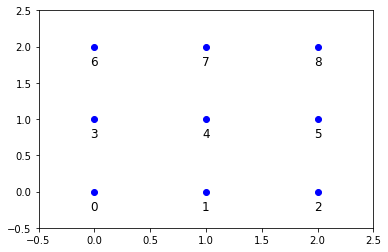

In [11]:
sous_salles = {i: (i%room_size[1], (i)//room_size[1])for i in range(num_virtual_rooms)}

trajectory2 = immersion_groups[1].trajectory
trajectoire2 = trajectory2
print(trajectoire2)

fig, ax = plt.subplots()

# Initialisation des sous-salles
for num_salle, (x, y) in sous_salles.items():
    ax.plot(x, y, 'bo')  # 'bo' pour représenter les points en bleu (blue circles)
    ax.text(x, y, '\n\n' + str(num_salle), fontsize=12, ha='center', va='center')  # Numéro de la salle

# Initialisation de la trajectoire (ligne vide)
line2, = ax.plot([], [], 'b-', animated = True)  # Utilisation d'une ligne rouge

# Définir les limites de l'axe
ax.set_ylim(-0.5, room_size[0]-0.5)
ax.set_xlim(-0.5, room_size[1]-0.5)

nombre_points = 10
valeurs_X2 = []
valeurs_Y2 = []

for i in range(len(trajectoire2) - 1):
    salle_depart = trajectoire2[i]
    salle_arrivee = trajectoire2[i + 1]
    x_dep, y_dep = sous_salles[salle_depart]
    x_arr, y_arr = sous_salles[salle_arrivee]
    
    if (x_arr - x_dep) == 0:
        pas_y = (y_arr - y_dep) / (nombre_points - 1)
        valeurs_y = [y_dep + i * pas_y for i in range(nombre_points)]
        valeurs_x = [x_dep for y in valeurs_y]
    else:
        m = (y_arr-y_dep)/(x_arr - x_dep)
        b = y_dep - m * x_dep
        pas_x = (x_arr - x_dep) / (nombre_points - 1)
        valeurs_x = [x_dep + i * pas_x for i in range(nombre_points)]
        valeurs_y = [m * x + b for x in valeurs_x]
    
    valeurs_X2 += valeurs_x
    valeurs_Y2 += valeurs_y


[0, 1, 2, 1, 3]
[0, 4, 2, 4, 1]
[0, 4, 1, 4, 2]
[0, 5, 2, 5, 1]
[0, 3, 4, 3, 1]
[0, 3, 2, 3, 1]
[0, 4, 2, 4, 1]
[0, 4, 2, 4, 1]
[0, 3, 2, 3, 1]
[0, 5, 2, 5, 1]


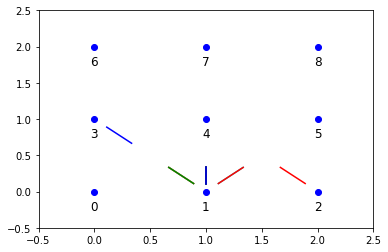

In [12]:
sous_salles = {i: (i%room_size[1], (i)//room_size[1])for i in range(num_virtual_rooms)}

fig, ax = plt.subplots()

# Initialisation des sous-salles
for num_salle, (x, y) in sous_salles.items():
    ax.plot(x, y, 'bo')  # 'bo' pour représenter les points en bleu (blue circles)
    ax.text(x, y, '\n\n' + str(num_salle), fontsize=12, ha='center', va='center')  # Numéro de la salle

# Initialisation de la trajectoire (ligne vide)
line2, = ax.plot([], [], 'b-', animated = True)  # Utilisation d'une ligne rouge

# Définir les limites de l'axe
ax.set_ylim(-0.5, room_size[0]-0.5)
ax.set_xlim(-0.5, room_size[1]-0.5)

#definir le temps maximale:
def extract_max_time(immersion_groups):
    max_time = float('-inf')
    for group in immersion_groups:
        for times in group.room_times.values():
            for time_range in times:
                max_time = max(max_time, time_range[1])
    return max_time

max_time = extract_max_time(immersion_groups)


def compute_trajectory_vectors(salle_depart, salle_arrivee, nombre_points):    
    x_dep, y_dep = sous_salles[salle_depart]
    x_arr, y_arr = sous_salles[salle_arrivee]

    if (x_arr - x_dep) == 0:
        pas_y = (y_arr - y_dep) / (nombre_points - 1)
        valeurs_y = [y_dep + i * pas_y for i in range(nombre_points)]
        valeurs_x = [x_dep for y in valeurs_y]
    else:
        m = (y_arr-y_dep)/(x_arr - x_dep)
        b = y_dep - m * x_dep
        pas_x = (x_arr - x_dep) / (nombre_points - 1)
        valeurs_x = [x_dep + i * pas_x for i in range(nombre_points)]
        valeurs_y = [m * x + b for x in valeurs_x]
        
    return valeurs_x, valeurs_y

def get_values(group):
    nombre_points = 10
    
    trajectory = group.trajectory
    trajectoire = trajectory
    print(trajectoire)
    valeurs_X = []*max_time
    valeurs_Y = []*max_time
    for i in range(len(trajectoire) - 1):
        salle_depart = trajectoire[i]
        salle_arrivee = trajectoire[i + 1]
        
        valeurs_x, valeurs_y = compute_trajectory_vectors(salle_depart, salle_arrivee, nombre_points)
        
        valeurs_X += valeurs_x
        valeurs_Y += valeurs_y
        
    return valeurs_X, valeurs_Y
    
    
valeurs_X_max = 0
l, = ax.plot([],[])
trajs = []
lines = []
colors = ['b-', 'g-', 'r-', 'c-', 'm-', 'y-', 'k-']
for k, group in enumerate(immersion_groups):
    vals_X, vals_Y = get_values(group)
    if(len(vals_X)>valeurs_X_max):
        valeurs_X_max = len(vals_X)
    trajs.append([vals_X, vals_Y])
    line, = ax.plot([], [], colors[k % len(colors)], animated=True)  # Utilisation d'une ligne rouge
    lines.append(line)

lineTest, = ax.plot([], [], 'r-', animated=True)
def animate(i):
    trace_len = 3
    for j in range(len(trajs)):
        lines[j].set_data(trajs[j][0][i-trace_len:i], trajs[j][1][i-trace_len:i])

ani = animation.FuncAnimation(fig, animate, frames=valeurs_X_max)

from IPython.display import HTML
HTML(ani.to_jshtml())

### Fonctions de population


[<__main__.Group object at 0x0000023F8501F4C0>, <__main__.Group object at 0x0000023F8501FB20>, <__main__.Group object at 0x0000023F8501FD00>, <__main__.Group object at 0x0000023F8501FA60>, <__main__.Group object at 0x0000023F8501F9D0>, <__main__.Group object at 0x0000023F8501FAF0>, <__main__.Group object at 0x0000023F8501FEE0>, <__main__.Group object at 0x0000023F8501FD30>, <__main__.Group object at 0x0000023F86024910>, <__main__.Group object at 0x0000023F86024D60>]


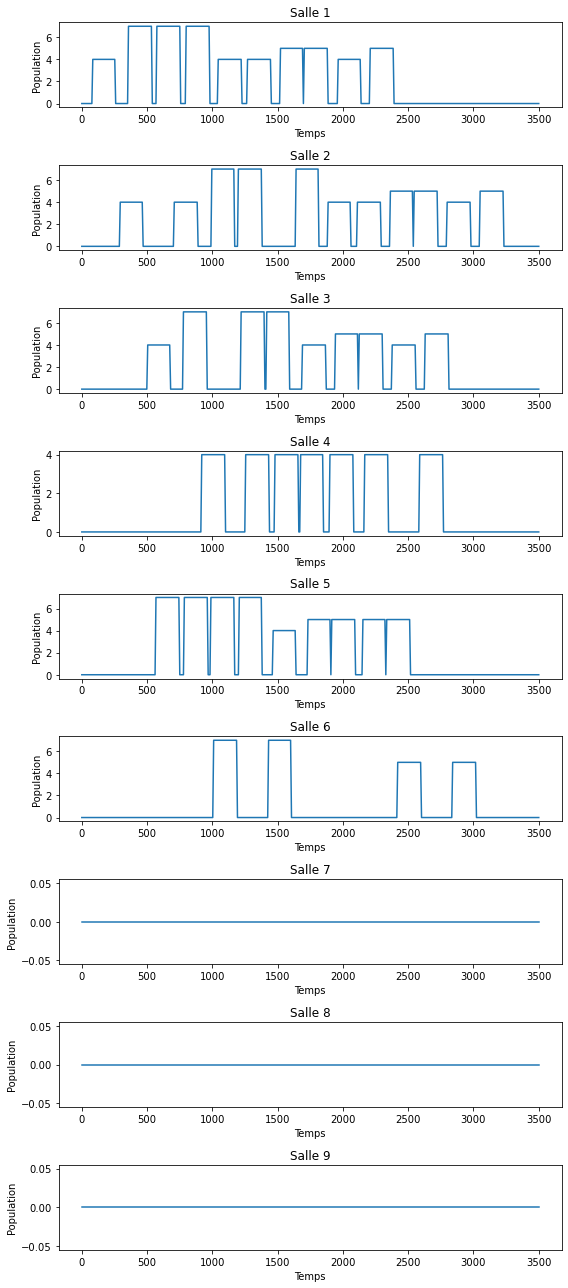

In [13]:
# Intervalle de temps
t_debut = 0
t_fin = 3500
temps = np.linspace(t_debut, t_fin, num=500)  # Choisir le nombre de points à tracer

print(immersion_groups)
fig, axes = plt.subplots(num_virtual_rooms, 1, figsize=(8, 2*num_virtual_rooms))  # 9 lignes, 1 colonne

# Pour chaque salle, tracer l'évolution de la population au cours du temps
for i, ax in enumerate(axes):
    population_array = np.array([population(t, immersion_groups) for t in temps])
    ax.plot(temps, population_array[:, i], label=f'Salle {i+1}')
    ax.set_xlabel('Temps')
    ax.set_ylabel('Population')
    ax.set_title(f'Salle {i+1}')

# Ajuster les espacements entre les graphiques
plt.tight_layout()

# Afficher les graphiques
plt.show()

[0, 1, 2, 1, 3]
[0, 4, 2, 4, 1]
[0, 4, 1, 4, 2]
[0, 5, 2, 5, 1]
[0, 3, 4, 3, 1]
[0, 3, 2, 3, 1]
[0, 4, 2, 4, 1]
[0, 4, 2, 4, 1]
[0, 3, 2, 3, 1]
[0, 5, 2, 5, 1]


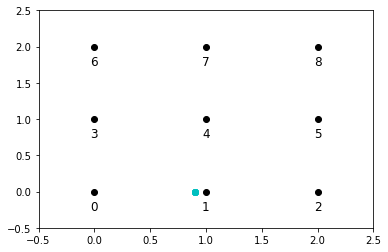

In [14]:
sous_salles = {i: (i%room_size[1], (i)//room_size[1])for i in range(num_virtual_rooms)}

fig, ax = plt.subplots()

# Initialisation des sous-salles
for num_salle, (x, y) in sous_salles.items():
    ax.plot(x, y, 'ko')  # 'bo' pour représenter les points en bleu (blue circles)
    ax.text(x, y, '\n\n' + str(num_salle), fontsize=12, ha='center', va='center')  # Numéro de la salle

# Initialisation de la trajectoire (ligne vide)
line2, = ax.plot([], [], 'b-', animated = True)  # Utilisation d'une ligne rouge

# Définir les limites de l'axe
ax.set_ylim(-0.5, room_size[0]-0.5)
ax.set_xlim(-0.5, room_size[1]-0.5)

#definir le temps maximale:
def extract_max_time(immersion_groups):
    max_time = float('-inf')
    for group in immersion_groups:
        for times in group.room_times.values():
            for time_range in times:
                max_time = max(max_time, time_range[1])
    return max_time

max_time = extract_max_time(immersion_groups)


def compute_trajectory_vectors(salle_depart, salle_arrivee, nombre_points):    
    x_dep, y_dep = sous_salles[salle_depart]
    x_arr, y_arr = sous_salles[salle_arrivee]

    if (x_arr - x_dep) == 0:
        pas_y = (y_arr - y_dep) / (nombre_points - 1)
        valeurs_y = [y_dep + i * pas_y for i in range(nombre_points)]
        valeurs_x = [x_dep for y in valeurs_y]
    else:
        m = (y_arr-y_dep)/(x_arr - x_dep)
        b = y_dep - m * x_dep
        pas_x = (x_arr - x_dep) / (nombre_points - 1)
        valeurs_x = [x_dep + i * pas_x for i in range(nombre_points)]
        valeurs_y = [m * x + b for x in valeurs_x]
        
    return valeurs_x, valeurs_y

n = 0.1 #nombre de points par seconde 

def get_values(group):
    nombre_points = 10
    start_time = group.initial_departure_time 
    room_time = group.room_time
    
    trajectory = group.trajectory
    trajectoire = trajectory
   
    valeurs_X = []*max_time
    valeurs_Y = []*max_time
    #valeurs_X = []*max_time
    #valeurs_Y = []*max_time
    
    premiere_salle = trajectoire[0]
    x_prem_salle, y_prem_salle = sous_salles[premiere_salle]   
    for i in range(round(n * (room_time + start_time))):
        valeurs_X.append(x_prem_salle)  
        valeurs_Y.append(y_prem_salle) 
    
    for i in range(len(trajectoire) - 1):
        salle_depart = trajectoire[i]
        salle_arrivee = trajectoire[i + 1]
        
        valeurs_x, valeurs_y = compute_trajectory_vectors(salle_depart, salle_arrivee, nombre_points)
        
        dernier_X = valeurs_x[-1]
        dernier_Y = valeurs_y[-1]
        valeurs_X += valeurs_x
        valeurs_Y += valeurs_y
        for i in range(round(n * room_time)):
            valeurs_X.append(dernier_X) 
            valeurs_Y.append(dernier_Y)
        
    return valeurs_X, valeurs_Y
    
    
valeurs_X_max = 0
trajs = {}
lines = {}
colors = ['b-', 'g-', 'r-', 'c-', 'm-', 'y-']
for k, group in enumerate(immersion_groups):
    print(group.trajectory)
    vals_X, vals_Y = get_values(group)
    if(len(vals_X)>valeurs_X_max):
        valeurs_X_max = len(vals_X)
    trajs[group.group_id] = [vals_X, vals_Y]
    line, = ax.plot([], [], colors[k % len(colors)], animated=True)  # Utilisation d'une ligne rouge
    lines[group.group_id] = line

def animate(i):
    #opc 1
    #trace_len = 3
    
    for key, values in trajs.items():
        #opc 2
        trace_len = immersion_groups[key].num_people
        lines[key].set_data(values[0][i-trace_len:i], values[1][i-trace_len:i])
        lines[key].set_marker("o")
        if all(x == values[0][i-trace_len] for x in values[0][i-trace_len:i])  and all(x == values[1][i-trace_len] for x in values[1][i-trace_len:i]) :
            lines[key].set_data([x + 0.1*(key%3-1) for x in values[0][i-trace_len:i]], values[1][i-trace_len:i])
        
        #opc 1
        #lines[key].set_data(values[0][i-trace_len:i], values[1][i-trace_len:i])
        #if all(x == values[0][i-trace_len] for x in values[0][i-trace_len:i])  and all(x == values[1][i-trace_len] for x in values[1][i-trace_len:i]) :
        #    lines[key].set_marker("o")
        #    lines[key].set_data([x + 0.1*(key%3-1) for x in values[0][i-trace_len:i]], values[1][i-trace_len:i])
        #else:
        #    lines[key].set_marker(",")
            
ani = animation.FuncAnimation(fig, animate, frames=valeurs_X_max)

from IPython.display import HTML
HTML(ani.to_jshtml())

In [15]:
sous_salles = {i: ((i)//room_size[1],i%room_size[1] )for i in range(num_virtual_rooms)}
print(room_size[1])
print(room_size[0])
print(sous_salles)

3
3
{0: (0, 0), 1: (0, 1), 2: (0, 2), 3: (1, 0), 4: (1, 1), 5: (1, 2), 6: (2, 0), 7: (2, 1), 8: (2, 2)}
